In [28]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: marcodia
"""
import numpy as np
import random
import xarray as xr
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys
import os 

!ln -s /Users/marcodia/Research/lowfreq_S2S_project/network_arch.ipynb network_arch.ipynb
!ln -s /Users/marcodia/Research/lowfreq_S2S_project/metrics.ipynb metrics.ipynb
!ln -s /Users/marcodia/Research/lowfreq_S2S_project/plot.ipynb plot.ipynb
!ln -s /Users/marcodia/Research/lowfreq_S2S_project/settings.ipynb settings.ipynb
!ln -s /Users/marcodia/Research/lowfreq_S2S_project/NN_train_robustness/functions_misc.ipynb functions_misc.ipynb

import network_arch as network
import metrics
import plot
import settings
import functions_misc as funcs

import cftime
import matplotlib.pyplot as plt
import nc_time_axis

from cartopy import config
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

ln: network_arch.ipynb: File exists
ln: metrics.ipynb: File exists
ln: plot.ipynb: File exists
ln: settings.ipynb: File exists
ln: functions_misc.ipynb: File exists


In [29]:
# MAKE THE NN ARCHITECTURE
def make_model():
    # Define and train the model
    tf.keras.backend.clear_session()
    model = network.defineNN(HIDDENS,
                             input1_shape = X_train.shape[1],
                             output_shape=NLABEL,
                             ridge_penalty1=RIDGE1,
                             dropout=DROPOUT,
                             act_fun='relu',
                             network_seed=NETWORK_SEED)
    
    loss_function = tf.keras.losses.CategoricalCrossentropy() 
    #loss_function = tf.keras.losses.SparseCategoricalCrossentropy() 
    model.compile(
                  optimizer = tf.keras.optimizers.Adam(learning_rate=LR_INIT),
                  loss = loss_function,
                  metrics = [
                      tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None),
                      metrics.PredictionAccuracy(NLABEL)
                      ]
                  )           
    return model, loss_function

In [30]:
#.............................................
# XAI functions
#.............................................

# before calling these functions in your notebook, make sure you have defined the tensorflow object "model". 
# The "model" is the machine learning model (e.g., neural network) that you want to explain. 

def get_gradients(inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model(inputs, training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

def get_integrated_gradients(inputs, baseline=None, num_steps=50, top_pred_idx=None):
    """Computes Integrated Gradients for a prediction.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.            

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with zeros
    # having same size as the input image.
    if baseline is None:
        input_size = np.shape(inputs)[1:]
        baseline = np.zeros(input_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    inputs = inputs.astype(np.float32)
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_inputs = np.array(interpolated_inputs).astype(np.float32)

    # 3. Get the gradients
    grads = []
    for i, x_data in enumerate(interpolated_inputs):
        grad = get_gradients(x_data, top_pred_idx=top_pred_idx)
        grads.append(grad)
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

def random_baseline_integrated_gradients(inputs, num_steps=50, num_runs=5, top_pred_idx=None):
    """Generates a number of random baseline images.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.      

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.zeros(np.shape(inputs)[1:])
        for i in np.arange(0,np.shape(baseline)[0]):
            j = np.random.choice(np.arange(0,np.shape(inputs)[0]))
            baseline[i] = inputs[j,i]

        igrads = get_integrated_gradients(
            inputs=inputs,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)



In [31]:
# <<< PARAMETERS >>>

num_experiments = 10
num_seeds = 10 
exp_num = 1

ind = 0
ind2 = 0

#confidence params
conf_level = 'most' #OR least
statement = 20
perc = 100-statement #percentile; this number can be stated as "the statement% conf_level confident predictions"; ex- the 20% most confident predictions  
subset = 'incorrect'

running_window_yr = 10 #running mean
days_per_annualszn = 30+31+31+28
running_window = running_window_yr * days_per_annualszn

YEARS = '1850-1949'
STRT = pd.to_datetime('11-01-1850')
END   = pd.to_datetime('2-28-1949')  + dt.timedelta(days=1)

timeplot_full = np.arange(1850,1950)
array_size = len(timeplot_full) - running_window_yr
timeplot = timeplot_full[running_window_yr:(len(timeplot_full))]

NLABEL = 2

prect_file = xr.open_dataarray('/Users/marcodia/Research/Data/processed_fields/Week_34/exp_1/exp_100/'+'PRECT_tropfullband_1850-1949_ens9_dailyanom_detrend.nc')#['SST']
prect_lat = np.array(prect_file.lat)
prect_lon = np.array(prect_file.lon)
#Xtest_time = np.array(Xtest.time)

accuracy_seed_winner_trained = xr.DataArray(np.zeros([num_experiments,array_size]),dims = ['experiment','year_avg'],coords = [('experiment',np.arange(0,num_experiments)),('year_avg',timeplot)])
# XAI_calc0 = xr.DataArray(np.zeros([num_experiments,11880,3168]))
# XAI_calc1 = xr.DataArray(np.zeros([num_experiments,11880,3168]))
overall_accuracy_all_trained = xr.DataArray(np.zeros([num_experiments,num_seeds]),dims = ['experiment','seed'],coords = [('experiment',np.arange(0,num_experiments)),('seed',np.arange(0,num_seeds))])

# XAI_calc0 = xr.DataArray(np.zeros([num_experiments,11880,len(prect_lat), len(prect_lon)]),dims = ['experiment','time','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)), ('time',Xtest_time),('lat',prect_lat), ('lon',prect_lon)])
# XAI_calc1 = xr.DataArray(np.zeros([num_experiments,11880,len(prect_lat), len(prect_lon)]),dims = ['experiment','time','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)), ('time',Xtest_time),('lat',prect_lat), ('lon',prect_lon)])

XAI_pred0_true0 = xr.DataArray(np.zeros([num_experiments,len(prect_lat), len(prect_lon)]),dims = ['experiment','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)),('lat',prect_lat), ('lon',prect_lon)])
XAI_pred1_true1 = xr.DataArray(np.zeros([num_experiments,len(prect_lat), len(prect_lon)]),dims = ['experiment','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)),('lat',prect_lat), ('lon',prect_lon)])

XAI_pred1_true0 = xr.DataArray(np.zeros([num_experiments,len(prect_lat), len(prect_lon)]),dims = ['experiment','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)),('lat',prect_lat), ('lon',prect_lon)])
XAI_pred0_true1 = xr.DataArray(np.zeros([num_experiments,len(prect_lat), len(prect_lon)]),dims = ['experiment','lat', 'lon'],coords = [('experiment',np.arange(0,num_experiments)),('lat',prect_lat), ('lon',prect_lon)])


# >>>>>>>>>>>>>>>>>>>>>

In [32]:
#for sub_exp in np.arange(500,504):
for sub_exp in np.arange(exp_num*100,exp_num*100+10):
    EXPERIMENT = 'exp_'+str(exp_num)+'/exp_'+str(sub_exp)

    Xdata_folder = 'exp_1/exp_'+str(sub_exp-(exp_num-1)*100)
    Ydata_folder = 'exp_'+str(exp_num)+'/exp_'+str(sub_exp)
    
    ddir_X = '/Users/marcodia/Research/Data/processed_fields/Week_34/'+Xdata_folder+'/'
    ddir_Y = '/Users/marcodia/Research/Data/processed_fields/Week_34/'+Ydata_folder+'/'
    ddir_in = '/Users/marcodia/Research/Data/processed_fields/Week_45/'+Ydata_folder+'/'# '/Users/marcodia/Research/lowfreq_S2S_project/'+Ydata_folder+'/'
    ddir_out = ddir_Y #'/Users/marcodia/Research/lowfreq_S2S_project/'+Ydata_folder+'/'
    ddir_figs = ddir_out
    
    params = settings.get_settings(EXPERIMENT)

    PREDICTOR_VAR  = params['PREDICTOR_VAR']           
    PREDICTAND_VAR = params['PREDICTAND_VAR']              
    REGION_TOR     = params['REGION_TOR']          
    REGION_TAND    = params['REGION_TAND']            
    training_ens   = params['training_ens']            
    validation_ens = params['validation_ens']           
    testing_ens    = params['testing_ens']           
    train_list     = params['train_list']           
    lead           = 21 #params['lead']            
    days_average   = params['days_average']            
    GLOBAL_SEED    = params['GLOBAL_SEED']            
    HIDDENS        = params['HIDDENS']          
    DROPOUT        = params['DROPOUT']            
    RIDGE1         = params['RIDGE1']                    
    LR_INIT        = params['LR_INIT']
    BATCH_SIZE     = params['BATCH_SIZE']           
    RANDOM_SEED    = params['RANDOM_SEED']            
    act_fun        = params['act_fun']            
    N_EPOCHS       = params['N_EPOCHS']           
    PATIENCE       = params['PATIENCE']   
    
#>>>>>SET UP <<<<<<<<<<<<<<<
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    tf.compat.v1.random.set_random_seed(GLOBAL_SEED)
    
    
    time_range = xr.cftime_range(str(STRT)[:10], str(END)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
    time_range_ndjf = time_range.where(funcs.is_ndjf(time_range.month)).dropna()
    TIME_X = xr.DataArray(time_range_ndjf + dt.timedelta(days=0), dims=['time'])     
    TIME_Y = xr.DataArray(time_range_ndjf + dt.timedelta(days=lead+days_average), dims=['time'])  #below comment explains time segmentation

        #Based on the 14-day running average, Dec 6 1850 corresponds to the prior 14days averaged together. 
        #So a Nov 1 1850 prediction is for 21 days later of the 3-4week future average
    
    # ----- X TRAINING ------
    X_finame = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+train_list+'_dailyanom_detrend.nc'
    X_all_full = xr.open_dataarray(ddir_X+X_finame)
    X_all = X_all_full.where(X_all_full.time == TIME_X, drop=True)


    Xtrain = X_all.stack(time_all=('ens','time')) # lat,lon,time*8 (8= number of training ens members) 
    Xtrain = Xtrain.transpose('time_all','lat','lon') # time*8,lat,lon

    Xtrain_std = np.std(Xtrain,axis=0)
    Xtrain_mean = np.mean(Xtrain,axis=0)
    Xtrain = (Xtrain-Xtrain_mean)/Xtrain_std
    X_train = Xtrain.stack(z=('lat','lon'))

    # ---------- X VALIDATION (and TESTING)----------
    X_finame  = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+str(validation_ens)+'_dailyanom_detrend.nc'
    Xval = xr.open_dataarray(ddir_X+X_finame)

    Xval= Xval.where(Xval.time == TIME_X, drop=True)
    Xval = (Xval - Xtrain_mean)/Xtrain_std

    X_TEST_finame  = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+str(testing_ens)+'_dailyanom_detrend.nc'
    Xtest = xr.open_dataarray(ddir_X+X_TEST_finame)

    Xtest = Xtest.where(Xtest.time == TIME_X, drop=True)
    Xtest = (Xtest - Xtrain_mean)/Xtrain_std

    #%% ----- Y TRAINING--------

    Ytrain_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_boxavg_'+YEARS+'_'+'ens'+train_list+'_dailyanom_detrend_14dayavg.nc'
    Y_all = xr.open_dataarray(ddir_Y+Ytrain_finame)
    Y_all= Y_all.where(Y_all.time == TIME_Y, drop=True)

    # ----- Standardize Y training -----
    Ytrain = Y_all[:,:]    #already box averaged so no lat or lon dimension 
    Ytrain = Ytrain.stack(time_all=('ens','time')) # time*8 (Ytrain time is actually 365*100-(13*8) because of 14-day average)
    Ytrain_med = np.median(Ytrain)
    Ytrain = Ytrain - Ytrain_med       #Subtracting the median forces the output above or below zero 

    # ----- Y VALIDATION --------
    Yval_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_boxavg_'+YEARS+'_'+'ens'+str(validation_ens)+'_dailyanom_detrend_14dayavg.nc'
    Yval_all  = xr.open_dataarray(ddir_Y+Yval_finame)
    Yval_all= Yval_all.where(Yval_all.time == TIME_Y, drop=True)

    # ----- Standardize Y validation -----
    Yval = Yval_all[:]
    Yval = Yval - Ytrain_med         

    # ----- Grab Y testing -----

    Ytest_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_boxavg_'+YEARS+'_'+'ens'+str(testing_ens)+'_dailyanom_detrend_14dayavg.nc'
    Ytest_all  = xr.open_dataarray(ddir_Y+Ytest_finame)
    Ytest_all= Ytest_all.where(Ytest_all.time == TIME_Y, drop=True)

    Ytest = Ytest_all[:]
    Ytest = Ytest - Ytrain_med 

    # ----- Make binary -----
    # training
    Ytrain[np.where(Ytrain>=0)[0]] = 1
    Ytrain[np.where(Ytrain<0)[0]]  = 0
    # validation
    Yval[np.where(Yval>=0)[0]] = 1
    Yval[np.where(Yval<0)[0]]  = 0
    # testing
    Ytest[np.where(Ytest>=0)[0]] = 1
    Ytest[np.where(Ytest<0)[0]]  = 0

    # make Yval have equal 0s and 1s so that random chance is 50%
    n_valzero = np.shape(np.where(Yval==0)[0])[0]
    n_valone  = np.shape(np.where(Yval==1)[0])[0]
    i_valzero = np.where(Yval==0)[0]
    i_valone  = np.where(Yval==1)[0]

    if n_valone > n_valzero:
        isubset_valone = np.random.choice(i_valone,size=n_valzero,replace=False)
        i_valnew = np.sort(np.append(i_valzero,isubset_valone))
        Yval = Yval.isel(time=i_valnew,drop=True)
        X_val  = Xval[i_valnew].stack(z=('lat','lon'))
    elif n_valone < n_valzero:
        isubset_valzero = np.random.choice(i_valzero,size=n_valone,replace=False)
        i_valnew = np.sort(np.append(isubset_valzero,i_valone))
        Yval = Yval.isel(time=i_valnew,drop=True)
        X_val  = Xval[i_valnew].stack(z=('lat','lon'))
    else:
        X_val = Xval.stack(z=('lat','lon'))
        
        
#     # make Ytest have equal 0s and 1s so that random chance is 50%
#     n_testzero = np.shape(np.where(Ytest==0)[0])[0]
#     n_testone  = np.shape(np.where(Ytest==1)[0])[0]
#     i_testzero = np.where(Ytest==0)[0]
#     i_testone  = np.where(Ytest==1)[0]

#     if n_testone > n_testzero:
#         isubset_testone = np.random.choice(i_testone,size=n_testzero,replace=False)
#         i_testnew = np.sort(np.append(i_testzero,isubset_testone))
#         Ytest = Ytest.isel(time=i_testnew,drop=True)
#         X_test  = Xtest[i_testnew].stack(z=('lat','lon'))
#     elif n_testone < n_testzero:
#         isubset_testzero = np.random.choice(i_testzero,size=n_testone,replace=False)
#         i_testnew = np.sort(np.append(isubset_testzero,i_testone))
#         Ytest = Ytest.isel(time=i_testnew,drop=True)
#         X_test  = Xtest[i_testnew].stack(z=('lat','lon'))
#     else:
#         X_test = Xtest.stack(z=('lat','lon'))

    # ----- Make one hot vector -----
    enc = preprocessing.OneHotEncoder()
    onehotlabels      = enc.fit_transform(np.array(Ytrain).reshape(-1, 1)).toarray()
    onehotlabels_val  = enc.fit_transform(np.array(Yval).reshape(-1, 1)).toarray()
    onehotlabels_test  = enc.fit_transform(np.array(Ytest).reshape(-1, 1)).toarray()

    X_test_calcs = Xtest.stack(z=('lat','lon'))
    
    hotlabels_test_calcs = onehotlabels_test[:,:NLABEL]

    #hotlabels_test_calcs = Ytest
    #>>>>>>>>Analyze test data on trained model<<<<<<<<
    NETWORK_SEED=0
    #model, LOSS = funcs.make_model() 
    model, LOSS = make_model() 
    #global model 
    
    tf.get_logger().setLevel('ERROR')
    
    
    #Need to redefine empty matrices for each experiment
    
    stored_accuracy = np.zeros(len(RANDOM_SEED))

    
    
    #<<<<< LOAD MODEL TO RUN CALCULATIONS ON PREDICTIONS >>>>>>>
    for SEED in RANDOM_SEED:
        overall_accuracy_all_trained[ind,:] = xr.open_dataarray(ddir_in+'overall_accuracy_testdata'+'_exp'+EXPERIMENT[-3:]+'_allseeds'+'.nc')
            
    seed_winner_trained = np.argmax(np.array(overall_accuracy_all_trained[ind,:]))
    
#     X0_ind = np.where(X_test_calcs=0)
#     X0 = X_test_calcs[X0_ind]
    
    #for SEED in [210]:
    for SEED in [RANDOM_SEED[seed_winner_trained]]:
        if ind < num_experiments:
            model.load_weights(ddir_Y+'_operationalseed'+str(SEED)+'.h5')

            X1= X_test_calcs.copy(deep=True)
            
            #<<<Apply testing data to trained model>>>>>>>>>>>>> 
            Ptest = model.predict(X_test_calcs)    #predicted values on test data - softmax output of confidence 
            Cptest_pred = Ptest.argmax(axis=1)     #0,1 of predicted  
            Cttest_true = hotlabels_test_calcs.argmax(axis=1) #true values on validation 
                  
            conf_pred_val = model.predict(X_val)           # softmax output
            cat_pred_val  = np.argmax(conf_pred_val, axis = 1) # categorical output
            max_conf_val  = np.max(conf_pred_val, axis = 1)   # predicted category confidence
          
            results_test = model.evaluate(X_test_calcs,hotlabels_test_calcs,verbose = 2) #prints out model evaluation 
            stored_accuracy[ind] = results_test[2] #2 hardcoded to get the accuracy (categorical and prediction accuracy are the same here)

        # ----- EVALUATE MODEL -----  
            conf_pred_test = model.predict(X_test_calcs)           # softmax output
            cat_pred_test  = np.argmax(conf_pred_test, axis = 1) # categorical output
            max_conf_test  = np.max(conf_pred_test, axis = 1)   # predicted category confidence
            
            #<<<< Rank data into most confident predictions for testing and validation>>>>>>>
            
            for p,per in enumerate(np.arange(0,100,5)):
                if ind < num_seeds: 
                    i_cover_test = np.where(max_conf_test >= np.percentile(max_conf_test,per))[0]
                    icorr_test   = np.where(cat_pred_test[i_cover_test] == Ytest[i_cover_test])[0]
#                     if len(i_cover_test) == 0:
#                         acc_test[ind,p] = 0.
#                     else:
#                         acc_test[ind,p] = (len(icorr_test)/len(i_cover_test)) * 100   
        
        
            # for p,per in enumerate(np.arange(0,100,5)):
            #     if ind < num_seeds: 
            #         i_cover_val = np.where(max_conf_val >= np.percentile(max_conf_val,per))[0]
            #         icorr_val   = np.where(cat_pred_val[i_cover_val] == Yval[i_cover_val])[0]
            #         if len(i_cover_val) == 0:
            #             acc_val[ind,p] = 0.
            #         else:
            #             acc_val[ind,p] = (len(icorr_val)/len(i_cover_val)) * 100
                
            #<<<<<<<<<<>>>>>>>>>>>>>
            
#             #<<<<<<<<<<Take window of accuracy>>>>>>>>>>>
#             for i in np.arange(0,len(Cptest_pred)-running_window_yr,(days_per_annualszn)):
#                 if (running_window+i) <= (len(Cptest_pred)):
#                     modelcorr_test = Cptest_pred[i:running_window+i]==Cttest_true[i:running_window+i]
#                     nmodelcorr_test = modelcorr_test[modelcorr_test].shape[0]
#                     ntest_test = Cttest_true[i:running_window+i].shape[0]
#                     index_test = int(i/days_per_annualszn)
#                     if index_test<99:
#                         accuracy_test[index_test] = 100*nmodelcorr_test/ntest_test
                        
#             accuracy_test_xr = xr.DataArray(accuracy_test)
#             filename = 'accuracy_testdata_'+str(running_window_yr)+'yr_runavg_exp'+EXPERIMENT[-3:]+'_seed'+str(SEED)+'.nc'
            #accuracy_test_xr.to_netcdf(ddir_out+filename, mode='w')
            
            #<<<<<<<<<<>>>>>>>>>>>>>
            
            #Calculate Accuracy for confident predictions 
            
#             for i in np.arange(0,len(Cptest_pred)-running_window_yr,(days_per_annualszn)):
#                  if (running_window+i) <= (len(Cptest_pred)):
            
#                     max_conf  = np.max(Ptest[i:running_window+i], axis = 1)   # predicted category confidence
#                     Cptest_pred_cut = Cptest_pred[i:running_window+i]
#                     Ytest_cut = Ytest[i:running_window+i]
                    
#                     if conf_level == 'most':
#                         i_cover = np.where(max_conf >= np.percentile(max_conf,perc))[0]  #find X% most confident predictions 
#                     if conf_level == 'least':
#                         i_cover = np.where(max_conf <= np.percentile(max_conf,perc))[0]  #find X% least confident predictions 
                        
#                     icorr   = np.where(Cptest_pred_cut[i_cover] == Ytest_cut[i_cover])[0]   #find where the confident predictions match the truth values (ie find correct); Ytest is the NOT onehotencoded Y-values 

#                     index_test = int(i/days_per_annualszn)
                    
#                     if index_test<99:
#                         acc_moving[ind,index_test] = (len(icorr)/len(i_cover)) * 100                #calculate accuracy; ind is the network seed  
            
            
#             acc_vs_conf_moving = xr.DataArray(acc_moving)
#             filename_moving = str(statement)+'confidence_vs_accuracy_'+str(running_window_yr)+'yr_runavg_'+EXPERIMENT[-3:]+'_allseeds.nc'
#             acc_vs_conf_moving.to_netcdf(ddir_out+filename_moving, mode='w',format='NETCDF4')
            
            #<<<<<<<<<<<Split most confident data into correct and incorrect>>>>>>>
            #softmax:
            
            max_logits = np.max(Ptest,axis=-1)
            if conf_level == 'most':
                i_cover = np.where(max_logits >= np.percentile(max_logits, perc))[0]
                
            if conf_level == 'least':
                i_cover = np.where(max_logits < np.percentile(max_logits, perc))[0]
                
                
            cat_true_conf = Cttest_true[i_cover]
            cat_pred_conf = Cptest_pred[i_cover]
            
            if subset == 'correct':
                #location of correct predictions
                icorr = np.where(Cptest_pred[i_cover] - Cttest_true[i_cover] == 0)[0]
                X1_subset = X1[i_cover][icorr] #index Xtest with indicies of CONFIDENT & CORRECT predictions; for output compositing, replace X1 with Y variable 
                X_subset_time = X1.time[i_cover][icorr] #index with indicies of CONFIDENT & CORRECT predictions
                Y_true_subset = cat_true_conf[icorr]
                Y_pred_subset = cat_pred_conf[icorr]
                time = X_test_calcs.time[icorr]
                
            if subset == 'incorrect': #confident but incorrect/wrong prediction
                #location of incorrect predictions
                i_incorr = np.where(Cptest_pred[i_cover] - Cttest_true[i_cover] != 0)[0]
                X1_subset = X1[i_cover][i_incorr] #index Xtest with indicies of INCORRECT predictions
                X_subset_time = X1.time[i_cover][i_incorr] #index with indicies of INCORRECT predictions
                Y_true_subset = cat_true_conf[i_incorr]
                Y_pred_subset = cat_pred_conf[i_incorr]
                time = X_test_calcs.time[i_incorr]
                
            if subset == 'all':    #all confident predictions (correct and incorrect) 
                i_incorr = np.where(Cptest_pred[i_cover] - Cttest_true[i_cover] <= 1)[0]
                X1_subset = X1[i_cover][i_incorr] #index Xtest with indicies of INCORRECT predictions
                X_subset_time = X1.time[i_cover][i_incorr] #index with indicies of INCORRECT predictions
                Y_true_subset = cat_true_conf[i_incorr]
                Y_pred_subset = cat_pred_conf[i_incorr]
                time = X_test_calcs.time[i_incorr]
            
            # classes = np.arange(0,NLABEL)
            # for c in classes:
                
                #Data1map = Data1[:,:np.shape(X1_subset)[1]].unstack('z')
            
            # >>>>> LOOP THROUGH EACH CLASS: Calc & DATA MAPS FOR THE CLASS >>>>>
            # classes = np.arange(0,NLABEL)
            # for c in classes:
            #     sample = X1_subset.copy()
            #     icat = np.where(Y_true_subset == c)[0]# will be the same category as predicted if subset = 'correct'
                
#         ########
#         if ind < num_experiments:
#             model.load_weights(ddir_Y+'_operationalseed'+str(SEED)+'.h5')
#             #model.load_weights(ddir_out+str(sub_exp)+'_operationalseed'+str(SEED)+'.h5')

#             X1= X_test_calcs.copy(deep=True)
#             model = model
#             #<<<Apply testing data to trained model>>>>>>>>>>>>> 
#             Ptest = model.predict(X_test_calcs)    #predicted values on test data - softmax output of confidence 
#             Cptest_pred = Ptest.argmax(axis=1)     #0,1 of predicted  
#             Cttest_true = hotlabels_test_calcs.argmax(axis=1) #true values on validation 
#             #Cttest_true = .argmax(axis=1) #true values on validation 

#             conf_pred_val = model.predict(X_val)           # softmax output
#             cat_pred_val  = np.argmax(conf_pred_val, axis = 1) # categorical output
#             max_conf_val  = np.max(conf_pred_val, axis = 1)   # predicted category confidence
          
            # results_test = model.evaluate(X_test_calcs,hotlabels_test_calcs,verbose = 2) #prints out model evaluation 
            # stored_accuracy[ind] = results_test[2] #2 hardcoded to get the accuracy (categorical and prediction accuracy are the same here)

            sample = X1_subset.copy()
            icat = np.where(Y_true_subset == 0)[0]# will be the same category as predicted if subset = 'correct'
            time_class = time[icat]
            Data1 = X1_subset[icat]
            
            
            #file_dates = xr.open_dataarray(ddir_in+subset+'_'+str(statement)+'perc_'+conf_level+'confident_predictions_'+EXPERIMENT[-3:]+'_seed'+str(RANDOM_SEED[seed_winner_trained])+'_class'+str(0)+'.nc')

            
            correct_predictions0=Data1 #Ytest.where(Y_true_subset==Y_pred_subset)
            #correct_predictions_np = np.array(correct_predictions)
            #correct_predictions0 = X_test_calcs[correct_predictions_np==0]
            
            sample = X1_subset.copy()
            icat = np.where(Y_true_subset == 1)[0]# will be the same category as predicted if subset = 'correct'
            time_class = time[icat]
            Data1 = X1_subset[icat]
            
            correct_predictions1=Data1 #Ytest.where(Y_true_subset==Y_pred_subset)
            #correct_predictions_np = np.array(correct_predictions)
            #correct_predictions1 = X_test_calcs[correct_predictions_np==1]
            # correct_predictions=Ytest.where(Cptest_pred==Cttest_true)#.dropna(dim='time')
            # correct_predictions_np = np.array(correct_predictions)
            # correct_predictions0 = X_test_calcs[correct_predictions_np==0]
            # correct_predictions1 = X_test_calcs[correct_predictions_np==1]
            
#             XAI_pred0_true0_stack = get_integrated_gradients(correct_predictions0,baseline=None, num_steps=50, top_pred_idx=0)
#             XAI_pred0_true0_full0 = XAI_pred0_true0_stack.unstack()
#             XAI_pred0_true0[ind,:,:] = np.mean(XAI_pred0_true0_full0,axis=0)
#             if sub_exp == exp_num*100:
#                 XAI_pred0_true0_full = XAI_pred0_true0# _full0
#             else:
#                 XAI_pred0_true0_full= np.append(XAI_pred0_true0_full0,XAI_pred0_true0_full0,axis=0)
            
            
#             XAI_pred1_true1_stack = get_integrated_gradients(correct_predictions1,baseline=None, num_steps=50, top_pred_idx=1)
#             XAI_pred1_true1_full1 = XAI_pred1_true1_stack.unstack()
#             XAI_pred1_true1[ind,:,:] = np.mean(XAI_pred1_true1_full1,axis=0)
#             if sub_exp == exp_num*100:
#                 XAI_pred1_true1_full = XAI_pred1_true1_full1
#             else:
#                 XAI_pred1_true1_full= np.append(XAI_pred1_true1_full1,XAI_pred1_true1_full1,axis=0)

            XAI_pred0_true0_stack = get_integrated_gradients(correct_predictions0,baseline=None, num_steps=50, top_pred_idx=0)
            XAI_pred0_true0_full1 = XAI_pred0_true0_stack.unstack()
            if sub_exp == exp_num*100:
                XAI_pred0_true0_full = XAI_pred0_true0_full1
            else:
                XAI_pred0_true0_full= np.append(XAI_pred0_true0_full,XAI_pred0_true0_full1,axis=0)
            print(XAI_pred0_true0_full.shape)
            XAI_pred0_true0[ind,:,:] = np.mean(XAI_pred0_true0_full,axis=0)
            
            XAI_pred1_true1_stack = get_integrated_gradients(correct_predictions1,baseline=None, num_steps=50, top_pred_idx=1)
            XAI_pred1_true1_full1 = XAI_pred1_true1_stack.unstack()
            if sub_exp == exp_num*100:
                XAI_pred1_true1_full = XAI_pred1_true1_full1
            else:
                XAI_pred1_true1_full= np.append(XAI_pred1_true1_full,XAI_pred1_true1_full1,axis=0)
            print(XAI_pred1_true1_full.shape)
            XAI_pred1_true1[ind,:,:] = np.mean(XAI_pred1_true1_full,axis=0)
                
            # incorrect_predictions=Ytest.where(Cptest_pred!=Cttest_true)#.dropna(dim='time')
            # incorrect_predictions_np = np.array(incorrect_predictions)
            # incorrect_predictions0 = X_test_calcs[incorrect_predictions_np==0]
            # incorrect_predictions1 = X_test_calcs[incorrect_predictions_np==1]
            
#             XAI_pred1_true0_stack = get_integrated_gradients(incorrect_predictions1,baseline=None, num_steps=50, top_pred_idx=1)
#             XAI_pred1_true0_full = XAI_pred1_true0_stack.unstack()
#             XAI_pred1_true0[ind,:,:] = np.mean(XAI_pred1_true0_full,axis=0)
#             XAI_pred0_true1_stack = get_integrated_gradients(incorrect_predictions0,baseline=None, num_steps=50, top_pred_idx=0)
#             XAI_pred0_true1_full = XAI_pred0_true1_stack.unstack()
#             XAI_pred0_true1[ind,:,:] = np.mean(XAI_pred0_true1_full,axis=0)
            
            # XAI_calc0_temp = get_integrated_gradients(X_test_calcs[Ytest==0,:],baseline=None, num_steps=50, top_pred_idx=0)
            # XAI_calc0 = XAI_calc0_temp.unstack() #could input Cptest_pred to see attribution of what actually was predicted 
#             XAI_calc1_temp = get_integrated_gradients(X_test_calcs,baseline=None, num_steps=50, top_pred_idx=1)
#             XAI_calc1 = XAI_calc1_temp.unstack()
            
            # XAI_calc0_temp = get_integrated_gradients(X_test_calcs,baseline=None, num_steps=50, top_pred_idx=0)
            # XAI_calc0[ind,:,:] = XAI_calc0_temp.unstack() #could input Cptest_pred to see attribution of what actually was predicted 
            # XAI_calc1_temp = get_integrated_gradients(X_test_calcs,baseline=None, num_steps=50, top_pred_idx=1)
            # XAI_calc1[ind,:,:] = XAI_calc1_temp.unstack()
        # ----- EVALUATE MODEL -----  
            
    ind = ind+1 
    ind2 = ind2+1
        
        

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 409,826
Trainable params: 409,826
Non-trainable params: 0
_________________________________________________________________
352/352 [==============================] - 1s 2ms/step
372/372 - 1s - loss: 0.6898 - categorical_accuracy: 0.5601 - prediction_accuracy: 0.5601 - 728ms/epoch - 2ms/step
372/372 [=========

In [33]:
print('hi')

hi


In [34]:
XAI_pred0_true0_full.shape

(4828, 22, 144)

# Clustering Analysis

env: PYTHONHASHSEED=99


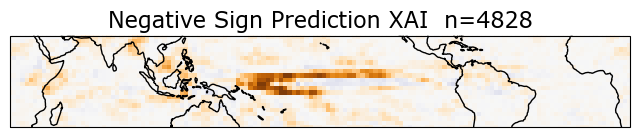

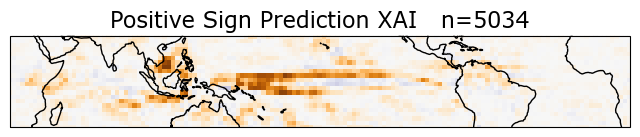

In [35]:
#print(EXPERIMENT[-3:])
# Clustering Analysis

# set random seed so we get identical results every time
%env PYTHONHASHSEED=99
np.random.seed(99)

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans,vq
import matplotlib.cm as cm
import matplotlib as mpl

linewidth_default = 2.0
fig_text_default = 18.
fig_title_default = fig_text_default*1.5

plt.rc('lines', linewidth=linewidth_default)    
plt.rc('text', usetex=False)
plt.rc('font', size=fig_text_default, weight='normal',family='sans-serif')
plt.rc('axes',titlesize=fig_title_default,titleweight='bold')
mpl.rcParams['figure.dpi'] = 100

XAI_pred0_true0_full #= xr.open_dataarray('/Users/marcodia/Research/lowfreq_S2S_project/scripts_for_publication/FOO_XAI_data/'+'XAI_true0_full_cali_highconf.nc')
data = np.array(XAI_pred0_true0_full)
lat = XAI_pred0_true0_full1.lat
lon = XAI_pred0_true0_full1.lon

#----------- MODIFY -------------------------
numclust = 1            # number of clusters to fit
n_iters_vec = [100,]     # number of full iterations run, then take the best one
#--------------------------------------------

dist_vec = np.asarray([])
for n_iters in n_iters_vec:
 #  clusters/nodes/centroids, sum distance/quantization error = kmeans(input data, #clusters, #iterations) 
    clusters, dist = kmeans(data.reshape(data.shape[0],data.shape[1]*data.shape[2]), numclust, iter=n_iters)
    classes, _ = vq(data.reshape(data.shape[0],data.shape[1]*data.shape[2]),clusters)
    dist_vec = np.append(dist_vec,dist)
# print('clusters shape = ' + str(clusters.shape))
# print('classes shape = ' + str(classes.shape))   

min_level = -0.0005 #(-10)^(-7)
max_level = 0.0005 #10^(-7)
step_level = 0.00005
levels = np.arange(min_level,max_level,step_level)
cmap = 'PuOr'
extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]

#plt.figure(figsize=(8*1.5,5*1.5*.66))

for cluster in np.arange(0,numclust):
    #ax = plt.subplot(2,int(np.ceil(numclust/2.)),cluster+1,projection=mapProj)
    fig, (ax0) = plt.subplots(nrows=1,ncols=1, figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=200)})
    xplot = clusters[cluster,:].reshape(len(lat),len(lon))
    count = np.count_nonzero(classes == cluster)
#    ax0.set_title('Negative Sign XAI Cluster '+str(cluster+1)+'    n='+str(count), fontsize = '16')
    ax0.set_title('Negative Sign Prediction XAI  n='+str(count), fontsize = '16', fontweight = 'light')
    #cf0 = ax0.pcolor(cyclic_lons,Xtest_lat,conf_correct_preds[0,1,:,:], transform = ccrs.PlateCarree(), cmap ='BrBG',vmin = min_level, vmax=max_level)
    xplot, cyclic_lons = add_cyclic_point(xplot, coord=prect_lon)
    cf0 = ax0.pcolor(cyclic_lons,XAI_pred0_true0_full1.lat,xplot, transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
    ax0.add_feature(cfeature.COASTLINE)
    ax0.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())
    plt.show()

XAI_pred1_true1_full #= xr.open_dataarray('/Users/marcodia/Research/lowfreq_S2S_project/scripts_for_publication/FOO_XAI_data/'+'XAI_true1_full_cali_highconf.nc')
data = np.array(XAI_pred1_true1_full)
#lat = XAI_pred1_true1_full1.lat
#lon = XAI_pred1_true1_full1.lon


#----------- MODIFY -------------------------
numclust = 1            # number of clusters to fit
n_iters_vec = [100,]     # number of full iterations run, then take the best one
#--------------------------------------------

dist_vec = np.asarray([])
for n_iters in n_iters_vec:
 #  clusters/nodes/centroids, sum distance/quantization error = kmeans(input data, #clusters, #iterations) 
    clusters, dist = kmeans(data.reshape(data.shape[0],data.shape[1]*data.shape[2]), numclust, iter=n_iters)
    classes, _ = vq(data.reshape(data.shape[0],data.shape[1]*data.shape[2]),clusters)
    dist_vec = np.append(dist_vec,dist)
# print('clusters shape = ' + str(clusters.shape))
# print('classes shape = ' + str(classes.shape))   

min_level = -0.0005 #(-10)^(-7)
max_level = 0.0005 #10^(-7)
step_level = 0.00005


levels = np.arange(min_level,max_level,step_level)
cmap = 'PuOr'
extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]

#plt.figure(figsize=(8*1.5,5*1.5*.66))

for cluster in np.arange(0,numclust):
    #ax = plt.subplot(2,int(np.ceil(numclust/2.)),cluster+1,projection=mapProj)
    fig, (ax0) = plt.subplots(nrows=1,ncols=1, figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=200)})
    xplot = clusters[cluster,:].reshape(len(lat),len(lon))
    count = np.count_nonzero(classes == cluster)
#    ax0.set_title('Positive Sign Prediction XAI Cluster '+str(cluster+1)+'    n='+str(count), fontsize = '16')
    ax0.set_title('Positive Sign Prediction XAI   n='+str(count), fontsize = '16', fontweight = 'light')

    #cf0 = ax0.pcolor(cyclic_lons,Xtest_lat,conf_correct_preds[0,1,:,:], transform = ccrs.PlateCarree(), cmap ='BrBG',vmin = min_level, vmax=max_level)
    xplot, cyclic_lons = add_cyclic_point(xplot, coord=prect_lon)
    cf0 = ax0.pcolor(cyclic_lons,XAI_pred1_true1_full1.lat,xplot, transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
    ax0.add_feature(cfeature.COASTLINE)
    ax0.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())
#    ax0.colorbar()
    plt.show()


In [32]:
#XAI_pred1_true1_full1

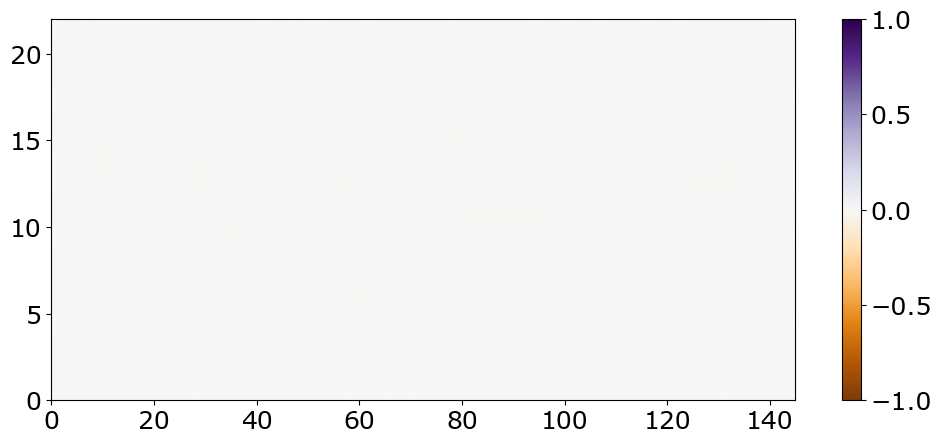

In [15]:
# min_level = -0.0005 #(-10)^(-7)
# max_level = 0.0005 #10^(-7)
# step_level = 0.00005
min_level = -1 #(-10)^(-7)
max_level = 1 #10^(-7)
step_level = 0.05
levels = np.arange(min_level,max_level,step_level)
cmap = 'PuOr'
extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]

plt.figure(figsize=(8*1.5,5*1.5*.66))
cf0 = plt.pcolor(xplot, cmap =cmap,vmin = min_level, vmax=max_level)
plt.colorbar()

# for cluster in np.arange(0,numclust):
#     #ax = plt.subplot(2,int(np.ceil(numclust/2.)),cluster+1,projection=mapProj)
#     fig, (ax0) = plt.subplots(nrows=1,ncols=1, figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=200)})
#     xplot = clusters[cluster,:].reshape(len(lat),len(lon))
#     count = np.count_nonzero(classes == cluster)
# #    ax0.set_title('Positive Sign Prediction XAI Cluster '+str(cluster+1)+'    n='+str(count), fontsize = '16')
#     ax0.set_title('Positive Sign Prediction XAI   n='+str(count), fontsize = '16')

#     #cf0 = ax0.pcolor(cyclic_lons,Xtest_lat,conf_correct_preds[0,1,:,:], transform = ccrs.PlateCarree(), cmap ='BrBG',vmin = min_level, vmax=max_level)
#     xplot, cyclic_lons = add_cyclic_point(xplot, coord=prect_lon)
#     cf0 = ax0.pcolor(cyclic_lons,XAI_pred1_true1_full1.lat,xplot, transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
#     ax0.add_feature(cfeature.COASTLINE)
#     ax0.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())
#     #ax0.colorbar()
#     plt.show()

## Plot XAI maps for ensemble members individually

In [ ]:
min_level = min_level #(-10)^(-7)
max_level = max_level #10^(-7)
step_level = step_level
cmap = cmap

fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(nrows=10,ncols=1, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=200)})
#tried many ways to make this a loop, eventually gave up esp bc ax needs to be in GeoAxesSubplot format
# if c == 0:
#     fig.suptitle(('Precip anomaly composite for '+subset+' '+str(statement)+'\% '+conf_level+' confident \n negative anom predictions in '+REGION_TAND), fontsize='16')
# else:
#     fig.suptitle(('Precip anomaly composite for '+subset+' '+str(statement)+'\% '+conf_level+' confident \n positive anom predictions in '+REGION_TAND), fontsize='16')

fontsize=10
#-----------------------------------------

ax0.set_title('Test Member 9', fontsize = fontsize)
#cf0 = ax0.pcolor(cyclic_lons,Xtest_lat,conf_correct_preds[0,1,:,:], transform = ccrs.PlateCarree(), cmap ='BrBG',vmin = min_level, vmax=max_level)
cf0 = ax0.pcolor(cyclic_lons,Xtest_lat,comp0[0,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax0.add_feature(cfeature.COASTLINE)
ax0.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())
# gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.0, linestyle='--')
# gl.xlabels_top = False
# gl.xlabels_bottom = True
# gl.ylabels_left = True
# gl.xlocator = mticker.FixedLocator(np.arange(-180,180,40))
# gl.ylocator = mticker.FixedLocator(np.arange(-80,80,20))
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 16, 'color': 'black'} #change size and color of x,y labels using cartopy formatter
# gl.ylabel_style = {'size': 16, 'color': 'black'}
# #-----------------------------------------

ax1.set_title('Test Member 0', fontsize = fontsize)
cf1 = ax1.pcolor(cyclic_lons,Xtest_lat,comp0[1,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax1.add_feature(cfeature.COASTLINE)
ax1.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax2.set_title('Test Member 1', fontsize = fontsize)
cf2 = ax2.pcolor(cyclic_lons,Xtest_lat,comp0[2,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax2.add_feature(cfeature.COASTLINE)
ax2.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax3.set_title('Test Member 2', fontsize = fontsize)
cf3 = ax3.pcolor(cyclic_lons,Xtest_lat,comp0[3,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax3.add_feature(cfeature.COASTLINE)
ax3.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax4.set_title('Test Member 3', fontsize = fontsize)
cf4 = ax4.pcolor(cyclic_lons,Xtest_lat,comp0[4,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax4.add_feature(cfeature.COASTLINE)
ax4.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax5.set_title('Test Member 4', fontsize = fontsize)
cf5 = ax5.pcolor(cyclic_lons,Xtest_lat,comp0[5,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax5.add_feature(cfeature.COASTLINE)
ax5.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax6.set_title('Test Member 5', fontsize = fontsize)
cf6 = ax6.pcolor(cyclic_lons,Xtest_lat,comp0[6,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax6.add_feature(cfeature.COASTLINE)
ax6.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax7.set_title('Test Member 6', fontsize = fontsize)
cf7 = ax7.pcolor(cyclic_lons,Xtest_lat,comp0[7,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax7.add_feature(cfeature.COASTLINE)
ax7.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax8.set_title('Test Member 7', fontsize = fontsize)
cf8 = ax8.pcolor(cyclic_lons,Xtest_lat,comp0[8,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax8.add_feature(cfeature.COASTLINE)
ax8.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax9.set_title('Test Member 8', fontsize = fontsize)
cf9 = ax9.pcolor(cyclic_lons,Xtest_lat,comp0[9,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax9.add_feature(cfeature.COASTLINE)
ax9.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

# gl = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.0, linestyle='--')
# gl.xlabels_top = False
# gl.xlabels_bottom = True
# gl.ylabels_left = True
# gl.xlocator = mticker.FixedLocator(np.arange(-180,180,40))
# gl.ylocator = mticker.FixedLocator(np.arange(-80,80,20))
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 8, 'color': 'black'} #change size and color of x,y labels using cartopy formatter
# gl.ylabel_style = {'size': 8, 'color': 'black'}

fig.subplots_adjust(top=0.92, wspace = 0.0, hspace = 0.3)

# cb = plt.colorbar()#cf9, cax=cax, location='bottom', label='mm/day')
# #cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal', label='mm/day',ticks=np.arange(min_level, max_level + step_level, step_level), pad=0.07, shrink = 0.8)

# cb.ax.tick_params(labelsize = 14)
# cb.set_label(label='mm/day', size = 'xx-large')

In [ ]:
min_level = min_level #(-10)^(-7)
max_level = max_level #10^(-7)
step_level = step_level
cmap = cmap

fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(nrows=10,ncols=1, figsize=(20, 12), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=200)})
#tried many ways to make this a loop, eventually gave up esp bc ax needs to be in GeoAxesSubplot format
# if c == 0:
#     fig.suptitle(('Precip anomaly composite for '+subset+' '+str(statement)+'\% '+conf_level+' confident \n negative anom predictions in '+REGION_TAND), fontsize='16')
# else:
#     fig.suptitle(('Precip anomaly composite for '+subset+' '+str(statement)+'\% '+conf_level+' confident \n positive anom predictions in '+REGION_TAND), fontsize='16')

fontsize=10
#-----------------------------------------

ax0.set_title('Test Member 9', fontsize = fontsize)
#cf0 = ax0.pcolor(cyclic_lons,Xtest_lat,conf_correct_preds[0,1,:,:], transform = ccrs.PlateCarree(), cmap ='BrBG',vmin = min_level, vmax=max_level)
cf0 = ax0.pcolor(cyclic_lons,Xtest_lat,comp1[0,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax0.add_feature(cfeature.COASTLINE)
ax0.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())
# gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.0, linestyle='--')
# gl.xlabels_top = False
# gl.xlabels_bottom = True
# gl.ylabels_left = True
# gl.xlocator = mticker.FixedLocator(np.arange(-180,180,40))
# gl.ylocator = mticker.FixedLocator(np.arange(-80,80,20))
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 16, 'color': 'black'} #change size and color of x,y labels using cartopy formatter
# gl.ylabel_style = {'size': 16, 'color': 'black'}
# #-----------------------------------------

ax1.set_title('Test Member 0', fontsize = fontsize)
cf1 = ax1.pcolor(cyclic_lons,Xtest_lat,comp1[1,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax1.add_feature(cfeature.COASTLINE)
ax1.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax2.set_title('Test Member 1', fontsize = fontsize)
cf2 = ax2.pcolor(cyclic_lons,Xtest_lat,comp1[2,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax2.add_feature(cfeature.COASTLINE)
ax2.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax3.set_title('Test Member 2', fontsize = fontsize)
cf3 = ax3.pcolor(cyclic_lons,Xtest_lat,comp1[3,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax3.add_feature(cfeature.COASTLINE)
ax3.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax4.set_title('Test Member 3', fontsize = fontsize)
cf4 = ax4.pcolor(cyclic_lons,Xtest_lat,comp1[4,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax4.add_feature(cfeature.COASTLINE)
ax4.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax5.set_title('Test Member 4', fontsize = fontsize)
cf5 = ax5.pcolor(cyclic_lons,Xtest_lat,comp1[5,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax5.add_feature(cfeature.COASTLINE)
ax5.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax6.set_title('Test Member 5', fontsize = fontsize)
cf6 = ax6.pcolor(cyclic_lons,Xtest_lat,comp1[6,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax6.add_feature(cfeature.COASTLINE)
ax6.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax7.set_title('Test Member 6', fontsize = fontsize)
cf7 = ax7.pcolor(cyclic_lons,Xtest_lat,comp1[7,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax7.add_feature(cfeature.COASTLINE)
ax7.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax8.set_title('Test Member 7', fontsize = fontsize)
cf8 = ax8.pcolor(cyclic_lons,Xtest_lat,comp1[8,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax8.add_feature(cfeature.COASTLINE)
ax8.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

#-----------------------------------------

ax9.set_title('Test Member 8', fontsize = fontsize)
cf9 = ax9.pcolor(cyclic_lons,Xtest_lat,comp1[9,:,:], transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
ax9.add_feature(cfeature.COASTLINE)
ax9.set_extent([10,350,-26.5,26.5],crs=ccrs.PlateCarree())

# gl = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.0, linestyle='--')
# gl.xlabels_top = False
# gl.xlabels_bottom = True
# gl.ylabels_left = True
# gl.xlocator = mticker.FixedLocator(np.arange(-180,180,40))
# gl.ylocator = mticker.FixedLocator(np.arange(-80,80,20))
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 8, 'color': 'black'} #change size and color of x,y labels using cartopy formatter
# gl.ylabel_style = {'size': 8, 'color': 'black'}

fig.subplots_adjust(top=0.92, wspace = 0.0, hspace = 0.3)

# cb = plt.colorbar()#cf9, cax=cax, location='bottom', label='mm/day')
# #cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal', label='mm/day',ticks=np.arange(min_level, max_level + step_level, step_level), pad=0.07, shrink = 0.8)

# cb.ax.tick_params(labelsize = 14)
# cb.set_label(label='mm/day', size = 'xx-large')